#### Import libraries

In [1]:

import os
import time
import math
import json

import re
import string

from collections import defaultdict

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from IPython.display import Image, display

#### Text Detection using roboflow API

In [2]:
from roboflow import Roboflow

# load object detection model from Roboflow
rf = Roboflow(api_key="S2g9XxR8N5xMQ5Ntxro8")
project = rf.workspace().project("resume-parsing-odjft")
roboflow_model = project.version(3).model

loading Roboflow workspace...
loading Roboflow project...


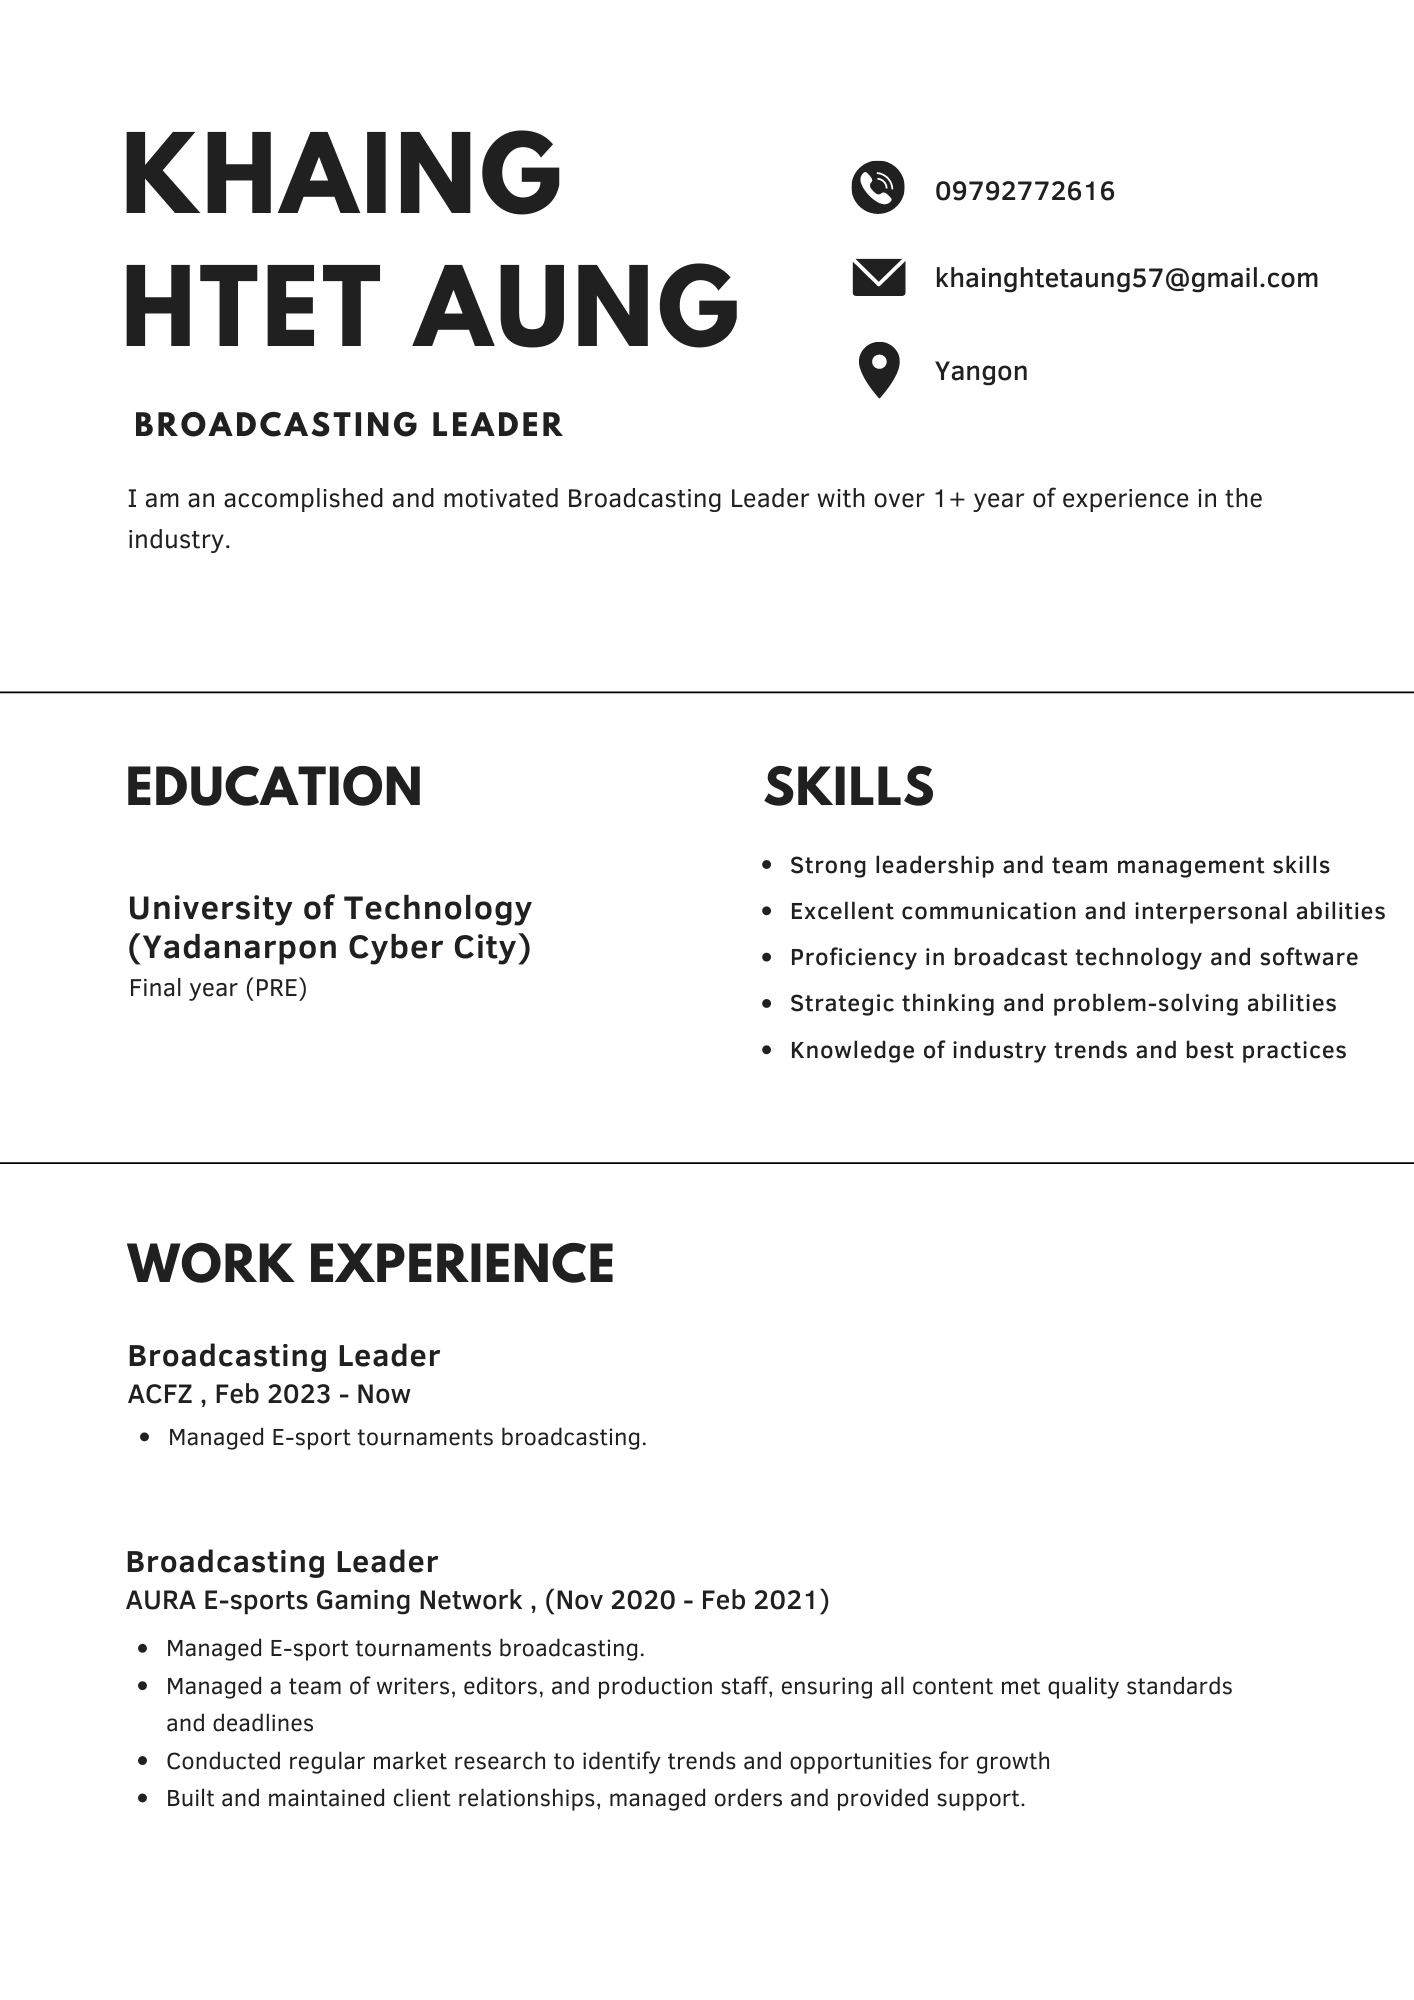

In [3]:
# Original image sample
image_path = "./sample_data/simple_resume.png"
display(Image(image_path, width=300, height=500))

In [4]:
# inference on local image
start_time = time.time()
predictions = roboflow_model.predict(image_path, confidence=40, overlap=30)
elapsed_time = time.time() - start_time

print("Prediction: ", predictions.json())
print("Elapsed time: ", elapsed_time)

Prediction:  {'predictions': [{'x': 425, 'y': 237, 'width': 642, 'height': 256, 'confidence': 0.9337632656097412, 'class': 'Name', 'class_id': 8, 'image_path': './sample_data/simple_resume.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 705, 'y': 1529, 'width': 1186, 'height': 609, 'confidence': 0.9207817316055298, 'class': 'Experience', 'class_id': 5, 'image_path': './sample_data/simple_resume.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 1073, 'y': 910, 'width': 649, 'height': 334, 'confidence': 0.7356429100036621, 'class': 'skills', 'class_id': 13, 'image_path': './sample_data/simple_resume.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 349, 'y': 425, 'width': 446, 'height': 62, 'confidence': 0.7259044647216797, 'class': 'Profil', 'class_id': 9, 'image_path': './sample_data/simple_resume.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 1083, 'y': 289, 'width': 501, 'height': 296, 'confidence': 0.72441565990448, 'class': 'Contact', 'class_id': 3, 'im

In [5]:
# visualize your prediction
# roboflow_model.predict(image_path, confidence=40, overlap=30).save("prediction.jpg")

In [6]:
# https://github.com/roboflow/roboflow-computer-vision-utilities
def draw_bounding_boxes_roboflow(image_path, predictions):

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR to RGB (OpenCV uses BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # main bounding box coordinates from JSON response object
    # https://docs.roboflow.com/inference/hosted-api#response-object-format

    for result in predictions:
        x0 = result['x'] - result['width'] / 2
        x1 = result['x'] + result['width'] / 2
        y0 = result['y'] - result['height'] / 2
        y1 = result['y'] + result['height'] / 2

        # position coordinates: start = (x0, y0), end = (x1, y1)
        # color = RGB-value for bounding box color, (0,0,0) is "black"
        # thickness = stroke width/thickness of bounding box
        # draw and place bounding boxes
        start_point = (int(x0), int(y0))
        end_point = (int(x1), int(y1))

        cv2.rectangle(image, start_point, end_point, color=(0,0,0), thickness=2)
        
        # confidence
        confidence = math.ceil(result['confidence'])/100
        # print("Confidence --->",confidence)

        # class name
        class_name = result['class']
        # print("Class name -->", class_name)

        # object details
        org = start_point
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2

        cv2.putText(image, class_name, org, font, fontScale, color, thickness)
            
    return image
        

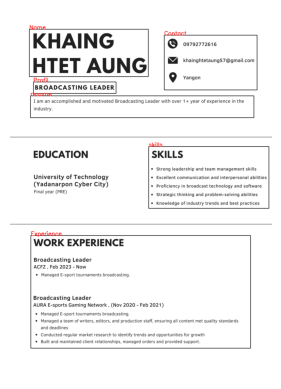

In [7]:
# inspect image
image = draw_bounding_boxes_roboflow(image_path, predictions)
# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

#### Text Detection using Custom YOLO

In [8]:
from ultralytics import YOLO

# load trained YOLO model
model = YOLO('./runs/detect/resume-parser2/weights/best.pt')

In [9]:
# inference on local image
start_time = time.time()
predictions = model.predict(image_path, conf=0.25)
elapsed_time = time.time() - start_time

print("Prediction: ", predictions[0])
print("Elapsed time: ", elapsed_time)



image 1/1 /home/oliver/Desktop/Workspace/resume-parser/resume_parser/sample_data/simple_resume.png: 800x576 1 Contact, 1 Education, 1 Experience, 1 Name, 1 Profil, 1 resume, 1 skills, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 336.7ms postprocess per image at shape (1, 3, 800, 576)


Prediction:  ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Contact', 1: 'Education', 2: 'Experience', 3: 'Interests', 4: 'Languages', 5: 'Name', 6: 'Profil', 7: 'Projects', 8: 'image', 9: 'resume', 10: 'skills'}
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

    

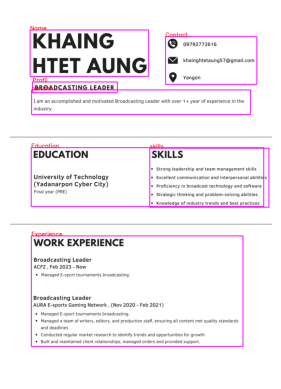

In [10]:
def draw_bounding_boxes_yolo(image_path, predictions):
    
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR to RGB (OpenCV uses BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in predictions:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # width, height = x2-x1, y2-y1
            
            # put box in image
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 255), 3)
            
            # confidence
            confidence = math.ceil((box.conf[0]*100))/100
            # print("Confidence --->",confidence)

            # class name
            cls = int(box.cls[0])
            # print("Class name -->", model.names[cls])

            # object details
            org = [x1, y1]
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            color = (255, 0, 0)
            thickness = 2

            cv2.putText(image, model.names[cls], org, font, fontScale, color, thickness)   
        
        return image
        

image = draw_bounding_boxes_yolo(image_path, predictions) 
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

#### DOCX to PDF Convertor

Spire.Doc - https://medium.com/@alice.yang_10652/convert-word-documents-to-images-png-jpg-bmp-with-python-e53f5ed823d1

In [11]:
import sys
import subprocess

class LibreOfficeError(Exception):
    """
    Custom exception for LibreOffice errors.
    """
    def __init__(self, output):
        self.output = output

def convert_to_pdf(docx_path, output_path, timeout=None):
    """
    Convert a document to PDF using LibreOffice.

    :param output_path: The output output_path for the converted PDF.
    :param docx_path: The path to the docx_path document.
    :param timeout: Timeout for the LibreOffice conversion process.
    :return: The name of the converted PDF file.
    :raises LibreOfficeError: If the conversion fails.
    """
    args = [libreoffice_exec(), '--headless', '--convert-to', 'pdf', '--outdir', output_path, docx_path]

    process = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=timeout)
    filename_match = re.search('-> (.*?) using filter', process.stdout.decode())

    if filename_match is None:
        raise LibreOfficeError(process.stdout.decode())
    else:
        # return filename_match.group(1)
        pdf_filename = filename_match.group(1)
        return pdf_filename

def libreoffice_exec():
    """
    Get the path to the LibreOffice executable based on the platform.

    :return: The path to the LibreOffice executable.
    """
    if sys.platform == 'darwin':
        return '/Applications/LibreOffice.app/Contents/MacOS/soffice'
    return 'libreoffice'



resume_docx = "./sample_data/Alice Clark CV.docx"
output_path = './sample_data/generated_data/'
pdf_path = convert_to_pdf(resume_docx, output_path)

#### PDF to Image Convertor

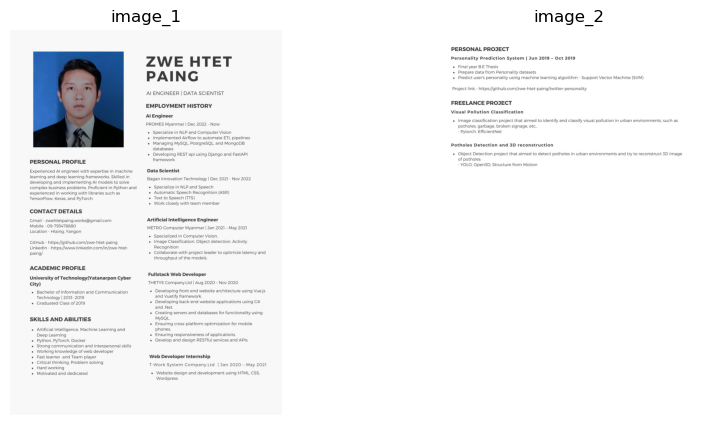

In [33]:
from pdf2image import convert_from_path

pdf_path = './sample_data/zwehtetpaing_resume.pdf'
images = convert_from_path(pdf_path, fmt='JPEG')

# save images
# for i in range(len(images)):
#     images[i].save('./pdf2image/page' + str(i) + '.jpg', 'JPEG')

# Display each image
plt.figure(figsize=(10, 5))
for i, image in enumerate(images, 1):
    plt.subplot(1, len(images), i)
    plt.title(f"image_{i}")
    plt.imshow(image)
    plt.axis('off')
plt.show()

#### OCR - Pytesseract and EasyOCR

In [34]:
# Tesseract OCR
import pytesseract

# Easy OCR
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

In [35]:
def perform_ocr_roboflow(image, predictions, ocr_engine='easyocr'):
    """
    Perform OCR on the cropped regions of the image based on predictions.

    :param image: PIL Image object.
    :param predictions: List of dictionaries containing object detection results.
    :param ocr_engine: String indicating the OCR engine to use ('tesseract' or 'easyocr').
    :return: A defaultdict(list) with class names and corresponding extracted texts.
    """
    text_dict = defaultdict(list)
    origin_image = image.convert('RGB')

    for item in predictions:
        x, y, width, height = item["x"], item["y"], item["width"], item["height"]
        class_name = item["class"]

        x1, y1, x2, y2 = x - (width / 2), y - (height / 2), x + (width / 2), y + (height / 2)

        # Crop the image
        cropped_image = origin_image.crop((x1, y1, x2, y2))
        
        # Draw bounding box on the original image
        draw = ImageDraw.Draw(origin_image)
        draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
        # Specify the font and size
        font = ImageFont.load_default()
        # font = ImageFont.truetype("font.ttf", 20)
        draw.text((x1, y1 - 10), class_name, fill="green", font=font)

        # Convert the image to grayscale (often improves OCR accuracy)
        gray_image = cropped_image.convert("L")

        # Perform text detection using the selected OCR engine
        if ocr_engine == 'tesseract':
            text = pytesseract.image_to_string(gray_image)
        elif ocr_engine == 'easyocr':
            text_results = reader.readtext(np.array(gray_image))
            text = ' '.join([txt[1] for txt in text_results])
        else:
            raise ValueError("Invalid OCR engine. Use 'tesseract' or 'easyocr'.")

        text_dict[class_name].append(text)
        
    return text_dict, origin_image

In [36]:
def perform_ocr_yolo(image, predictions, ocr_engine='easyocr'):
    """
    Perform OCR on the cropped regions of the image based on predictions.

    :param image: PIL Image object.
    :param predictions: List of dictionaries containing object detection results.
    :param ocr_engine: String indicating the OCR engine to use ('tesseract' or 'easyocr').
    :return: A defaultdict(list) with class names and corresponding extracted texts.
    """
    text_dict = defaultdict(list)
    origin_image = image.convert('RGB')

    result = predictions[0]
    
    for box in result.boxes:  
        x1, y1, x2, y2 = [
            round(coord) for coord in box.xyxy[0].tolist()
        ]
        class_name = model.names[box.cls[0].item()]

        # Crop the image using PILLOW
        cropped_image = origin_image.crop((x1, y1, x2, y2))
        
        # Draw bounding box on the original image
        draw = ImageDraw.Draw(origin_image)
        draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
        # Specify the font and size
        font = ImageFont.load_default()
        # font = ImageFont.truetype("font.ttf", 20)
        draw.text((x1, y1 - 10), class_name, fill="green", font=font)

        # Convert the image to grayscale (often improves OCR accuracy)
        gray_image = cropped_image.convert("L")

        # Perform text detection using the selected OCR engine
        if ocr_engine == 'tesseract':
            text = pytesseract.image_to_string(gray_image)
        elif ocr_engine == 'easyocr':
            text_results = reader.readtext(np.array(gray_image))
            text = ' '.join([txt[1] for txt in text_results])
        else:
            raise ValueError("Invalid OCR engine. Use 'tesseract' or 'easyocr'.")

        text_dict[class_name].append(text)

    return text_dict, origin_image

In [37]:
def process_images(images, model_type='roboflow', ocr_engine='easyocr'):
    """
    Process a list of images using the Roboflow model and extract text from detected regions.

    :param images: List of PIL Image objects.
    :param roboflow_model: Your Roboflow object detection model.
    :return: A list of defaultdict(list) with class names and corresponding extracted texts.
    """
    result_texts = []
    result_images = []
    start_time = time.time()
    for image in images:
        # Convert image to numpy array for Roboflow model prediction
        image_array = np.array(image)

        if model_type == 'roboflow':
            # Obtain predictions from the Roboflow model
            predictions = roboflow_model.predict(image_array, confidence=30, overlap=30)

            # Perform OCR and store the results
            text_dict, annotated_image = perform_ocr_roboflow(image, predictions, ocr_engine)
            
        elif model_type == 'yolo':
            # Obtain predictions from the Roboflow model
            predictions = model.predict(image_path, conf=0.20)
            
            # Perform OCR and store the results
            text_dict, annotated_image = perform_ocr_yolo(image, predictions, ocr_engine)
        
        result_texts.append(text_dict)
        result_images.append(annotated_image)
        
    execution_time  = time.time() - start_time
    print(f"Execution time {model_type}: {execution_time:.5f} seconds")

    return result_texts, result_images

In [60]:
# Process images and extract text
result_texts, result_images = process_images(images, model_type='roboflow', ocr_engine="easyocr")

# # Print or do something with the results
# for result in result_texts:
#     print(json.dumps(result, indent=4))

# result_images

Execution time roboflow: 11.66079 seconds


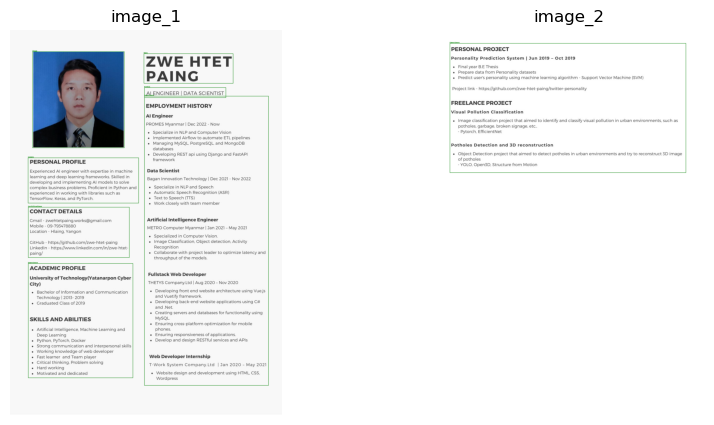

In [61]:
plt.figure(figsize=(10, 5))
for i, image in enumerate(result_images, 1):
    plt.subplot(1, len(images), i)
    plt.title(f"image_{i}")
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [62]:
final_dict = defaultdict(list)
for text_dict in result_texts:
    final_dict.update(text_dict)
    
print(json.dumps(final_dict, indent=4))

{
    "Certifications": [
        "CONTACT DETAILS Gmail zwehtetpaing works@gmail.com Mobile 09-793478880 Location Hlaing; Yangon GitHub https:Ilgithub.com/zwe-htet-paing Linkedln https:llwww.linkedin comlin/zwe-htet- paingl"
    ],
    "Experience": [
        "PERSONAL PROJECT Personality Prediction System Jun 2019 Oct 2019 Final year B.E Thesis Prepare data from Personality datasets Predict user's personality using machine learning algorithm Support Vector Machine (SVM) Project link https Ilgithubcom/zwe-htet-paing/twitter-personality FREELANCE PROJECT Visual Pollution Classification Image classification project that aimed to identify and classify visual pollution in urban environments, such as potholes, garbage; broken signage, etc_ Pytorch; EfficientNet Potholes Detection and 3D reconstruction Object Detection project that aimed to detect potholes in urban environments and try to reconstruct 3D image of potholes YOLO, Open3D, Structure from Motion"
    ],
    "image": [
        ""


In [63]:
full_text = ''

for class_name, text in final_dict.items():
    temp = ' '.join(text)
    full_text += temp
    
print(full_text)

CONTACT DETAILS Gmail zwehtetpaing works@gmail.com Mobile 09-793478880 Location Hlaing; Yangon GitHub https:Ilgithub.com/zwe-htet-paing Linkedln https:llwww.linkedin comlin/zwe-htet- painglPERSONAL PROJECT Personality Prediction System Jun 2019 Oct 2019 Final year B.E Thesis Prepare data from Personality datasets Predict user's personality using machine learning algorithm Support Vector Machine (SVM) Project link https Ilgithubcom/zwe-htet-paing/twitter-personality FREELANCE PROJECT Visual Pollution Classification Image classification project that aimed to identify and classify visual pollution in urban environments, such as potholes, garbage; broken signage, etc_ Pytorch; EfficientNet Potholes Detection and 3D reconstruction Object Detection project that aimed to detect potholes in urban environments and try to reconstruct 3D image of potholes YOLO, Open3D, Structure from MotionPERSONAL PROFILE Experienced Al engineer with expertise in machine learning and deep learning frameworks. Sk

In [64]:
full_text = ' '.join(' '.join(text) for class_name, text in final_dict.items())
print(full_text)

CONTACT DETAILS Gmail zwehtetpaing works@gmail.com Mobile 09-793478880 Location Hlaing; Yangon GitHub https:Ilgithub.com/zwe-htet-paing Linkedln https:llwww.linkedin comlin/zwe-htet- paingl PERSONAL PROJECT Personality Prediction System Jun 2019 Oct 2019 Final year B.E Thesis Prepare data from Personality datasets Predict user's personality using machine learning algorithm Support Vector Machine (SVM) Project link https Ilgithubcom/zwe-htet-paing/twitter-personality FREELANCE PROJECT Visual Pollution Classification Image classification project that aimed to identify and classify visual pollution in urban environments, such as potholes, garbage; broken signage, etc_ Pytorch; EfficientNet Potholes Detection and 3D reconstruction Object Detection project that aimed to detect potholes in urban environments and try to reconstruct 3D image of potholes YOLO, Open3D, Structure from Motion  PERSONAL PROFILE Experienced Al engineer with expertise in machine learning and deep learning frameworks.

#### Extract addictional information

-  https://www.analyticsvidhya.com/blog/2023/06/the-resume-parser-for-extracting-information-with-spacys-magic/

In [74]:
# !pip install pdfminer.six

In [79]:
from pdfminer.high_level import extract_text

def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)


extracted_text = extract_text(pdf_path)
print(extracted_text)

ZWE HTET
PAING

AI ENGINEER | DATA SCIENTIST

EMPLOYMENT HISTORY

AI Engineer

PROMES Myanmar | Dec 2022 - Now

Specialize in NLP and Computer Vision
Implemented Airflow to automate ETL pipelines
Managing MySQL, PostgreSQL, and MongoDB
databases
Developing REST api using Django and FastAPI
framework

Data Scientist

Bagan Innovation Technology | Dec 2021 - Nov 2022

Specialize in NLP and Speech
Automatic Speech Recognition (ASR)
Text to Speech (TTS)
Work closely with team member

Artificial Intelligence Engineer

METRO Computer Myanmar | Jan 2021 – May 2021

Specialized in Computer Vision. 
Image Classification, Object detection, Activity
Recognition 
Collaborate with project leader to optimize latency and
throughput of the models.

Fullstack Web Developer

THETYS Company.Ltd | Aug 2020 – Nov 2020

Developing front end website architecture using Vue.js
and Vuetify framework.
Developing back-end website applications using C#
and .Net.
Creating servers and databases for functionality usi

In [81]:
def preprocess_text(text):
    # Convert text to lowercase
    # text = text.lower()
    
    # Remove punctuation
    # text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('\n', ' ')
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# clean_text = preprocess_text(full_text)
clean_text = preprocess_text(extracted_text)

In [96]:
text_dict = {key : preprocess_text(value[0]) for key, value in final_dict.items() }
text_dict

{'Certifications': 'CONTACT DETAILS Gmail zwehtetpaing works@gmail.com Mobile 09-793478880 Location Hlaing; Yangon GitHub https:Ilgithub.com/zwe-htet-paing Linkedln https:llwww.linkedin comlin/zwe-htet- paingl',
 'Experience': "PERSONAL PROJECT Personality Prediction System Jun 2019 Oct 2019 Final year B.E Thesis Prepare data from Personality datasets Predict user's personality using machine learning algorithm Support Vector Machine (SVM) Project link https Ilgithubcom/zwe-htet-paing/twitter-personality FREELANCE PROJECT Visual Pollution Classification Image classification project that aimed to identify and classify visual pollution in urban environments, such as potholes, garbage; broken signage, etc_ Pytorch; EfficientNet Potholes Detection and 3D reconstruction Object Detection project that aimed to detect potholes in urban environments and try to reconstruct 3D image of potholes YOLO, Open3D, Structure from Motion",
 'image': '',
 'resume': 'PERSONAL PROFILE Experienced Al engineer

In [105]:
# Name
text_dict['Name']

'ZWE HTET PAING'

In [106]:
# Profil
text_dict['Profil']

'ENGINEER DATA SCIENTIST'

In [107]:
# Contact number
def extract_contact_number_from_resume(text):
    # Use regex pattern to find a potential contact number
    pattern = re.compile(r'\b\d{2}-\d{9}\b')
    
    # Search for the pattern in the text
    match = pattern.search(text)

    # Return the matched contact number (or None if not found)
    return match.group(0) if match else None

print(extract_contact_number_from_resume(clean_text))

09-793478880


In [108]:
# Email
def extract_email_from_resume(text):
    # Split the text into words
    words = text.split()

    # Use a list comprehension to find the first word containing '@'
    email = next((word.strip() for word in words if '@' in word), None)

    return email

print(extract_email_from_resume(clean_text))

zwehtetpaing.works@gmail.com


In [110]:
# Skills
def extract_skills_from_resume(text, skills_list):
    skills = []

    for skill in skills_list:
        pattern = r"\b{}\b".format(re.escape(skill))
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            skills.append(skill)

    return skills

skills_list = ['Python', 'Data Analysis', 'Machine Learning', 'Communication', 'Project Management', 'Deep Learning', 'SQL', 'Tableau']
extract_skills_from_resume(clean_text, skills_list)

['Python', 'Machine Learning', 'Communication', 'Deep Learning']

In [111]:
# Education
def extract_education_from_resume(text):
    education = []

    # List of education keywords to match against
    education_keywords = ['Bsc', 'B. Pharmacy', 'B Pharmacy', 'Msc', 'M. Pharmacy', 'Ph.D', 'Bachelor', 'Master']

    for keyword in education_keywords:
        pattern = r"(?i)\b{}\b".format(re.escape(keyword))
        match = re.search(pattern, text)
        if match:
            education.append(match.group())

    return education

extract_education_from_resume(clean_text)


['Bachelor']